Transfer learnt model from a model trained on VGG by unfreezing some existing layers

Anjali Bhardwaj - 500223877 

Jasdeep Kaur - 500224259 

Ajit Kulkarni - 500223502

In [89]:
!pip install pandas numpy opencv-python tensorflow scikit-learn scipy matplotlib seaborn


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [90]:
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf 
from tensorflow.keras.applications import EfficientNetB0 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D 
from tensorflow.keras.models import Model 
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import roc_curve, auc 
from sklearn.model_selection import train_test_split
from numpy import interp

In [91]:
data_path = "FaceExpressions\Dataset"

file_list = os.listdir(data_path)
csv_files = [file for file in file_list if file.endswith('.csv')]

for file in csv_files:
    file_path = os.path.join(data_path, file)
    try:
        df = pd.read_csv(file_path)
        print(f"Contents of {file}:")
        print(df)
    except Exception as e:
        print(f"Error reading the file {file}: {e}")

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Ajit\AppData\Local\Temp\ipykernel_33656\2179847553.py:1: SyntaxWarning: invalid escape sequence '\D'
  data_path = "FaceExpressions\Dataset"


In [92]:
#the categories taken and the number of samples from each category
categories = ['sad', 'surprise', 'happy', 'neutral', 'angry', 'ahegao']
num_samples = 150
img_size = (128, 128)  
test_size = 0.2  


In [93]:
image_paths = []
labels = []

In [94]:
# Sample image and collect label
for category in categories:
    category_path = os.path.join(data_path, category)
    if os.path.exists(category_path):
        image_files = [file for file in os.listdir(category_path) if file.endswith(('.png', '.jpg', '.jpeg'))]
        
        if len(image_files) >= num_samples:
            sampled_files = random.sample(image_files, num_samples)
        else:
            sampled_files = image_files
        
        category_paths = [os.path.join(category_path, file) for file in sampled_files]
        image_paths.extend(category_paths)
        labels.extend([category] * len(sampled_files))
    else:
        print(f"Category folder {category_path} does not exist")

In [95]:
# checking if image_paths and labels have the same length
print(f"Number of images: {len(image_paths)}")
print(f"Number of labels: {len(labels)}")
assert len(image_paths) == len(labels), "Mismatch between number of images and labels."

# Split the data into training and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=test_size, random_state=42)


Number of images: 900
Number of labels: 900


In [96]:
def load_and_preprocess_images(image_paths, img_size):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
            img = cv2.resize(img, img_size)  
            img = img / 255.0 
            images.append(img)
    return np.array(images)

In [97]:
from sklearn.preprocessing import LabelEncoder
# Load and preprocess images
X_train = load_and_preprocess_images(train_paths, img_size)

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
y_test = label_encoder.transform(test_labels)

# Printing shapes of the preprocessed data
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

# Printing label mappings
print("Label mappings:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{i}: {label}")

Training data shape: (720, 128, 128, 3)
Training labels shape: (720,)
Testing labels shape: (180,)
Label mappings:
0: ahegao
1: angry
2: happy
3: neutral
4: sad
5: surprise


Displaying training sample images for category: sad


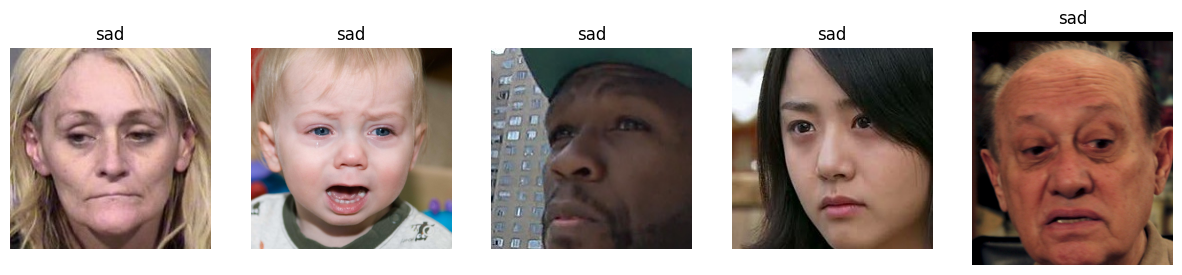

Displaying training sample images for category: surprise


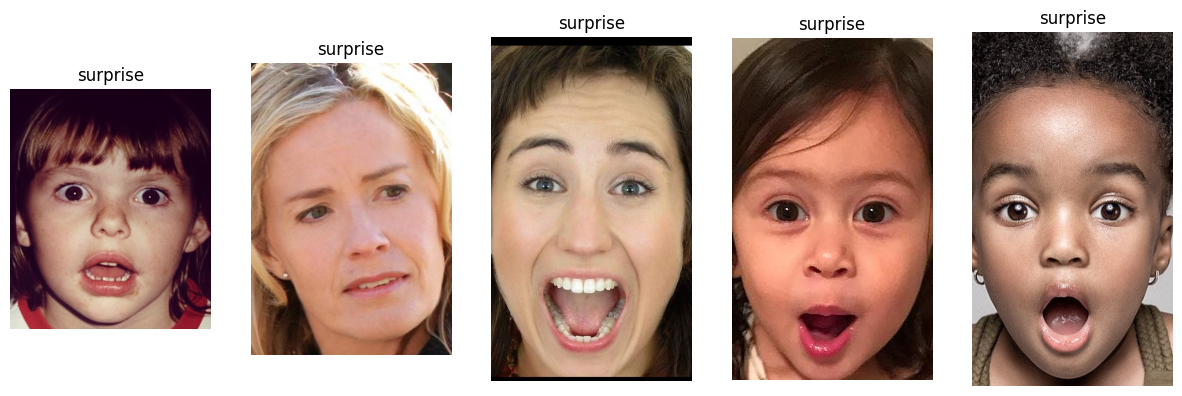

Displaying training sample images for category: happy


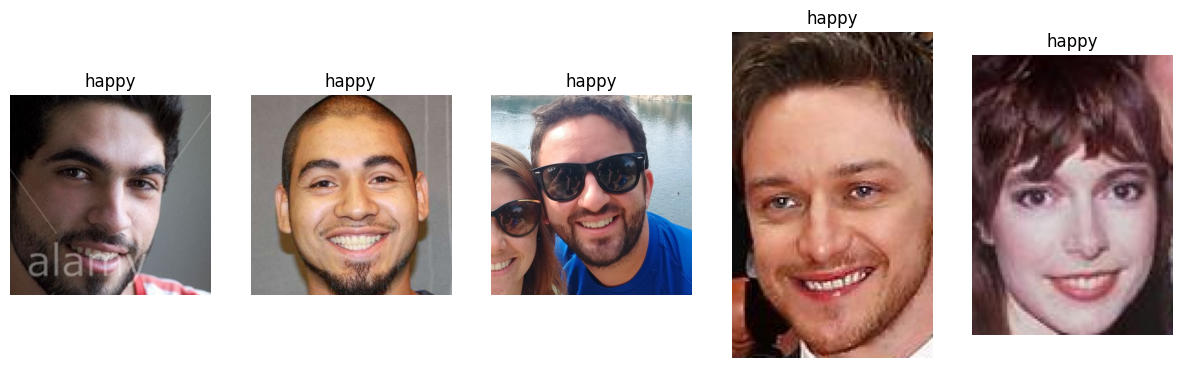

Displaying training sample images for category: neutral


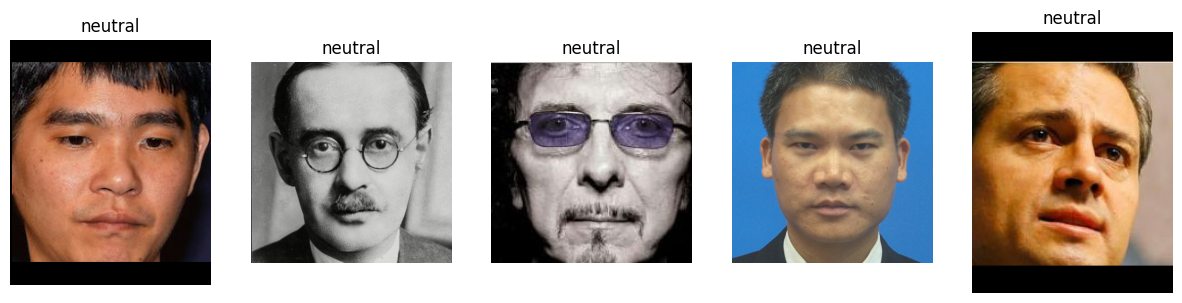

Displaying training sample images for category: angry


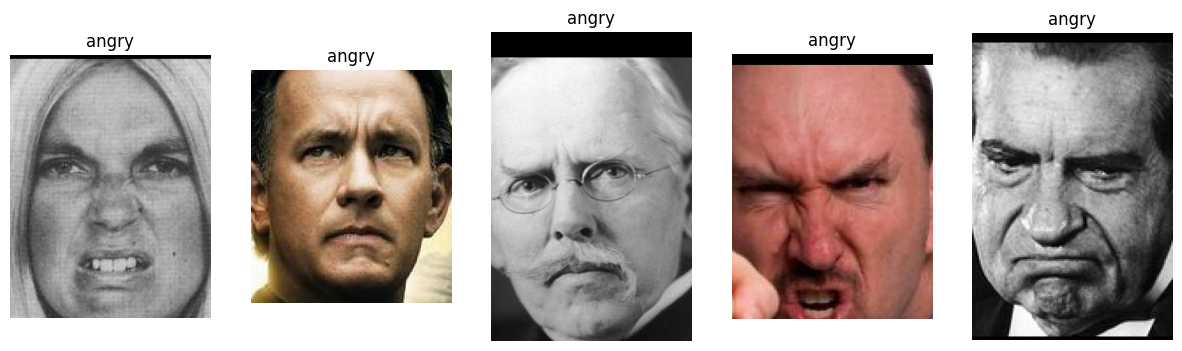

Displaying training sample images for category: ahegao


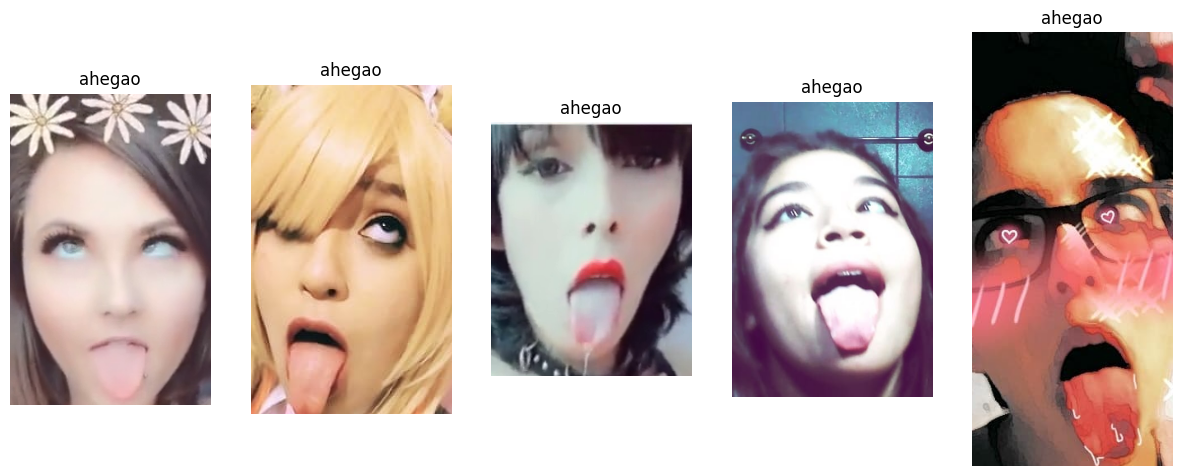

In [98]:
def display_images(image_paths, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        img_path = image_paths[i]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(os.path.basename(os.path.dirname(img_path)))  
        plt.axis('off')
    plt.show()

# Displaying images for each category from the training set
for category in categories:
    category_train_paths = [path for path in train_paths if os.path.basename(os.path.dirname(path)) == category]
    if category_train_paths:
        print(f"Displaying training sample images for category: {category}")
        display_images(category_train_paths, num_images=min(len(category_train_paths), 5))
        

In [99]:
# VGG16 model on pre-trained of ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

In [100]:
# Freezeing the layers except the last few
for layer in base_model.layers[:-4]:
    layer.trainable = False


In [101]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [102]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(len(categories), activation='softmax')(x)

In [103]:

model = Model(inputs=base_model.input, outputs=predictions)

In [104]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [105]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [106]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [107]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [108]:
# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(load_and_preprocess_images(test_paths, img_size), y_test), epochs=10, callbacks=[early_stopping])


Epoch 1/10


c:\Users\Ajit\Desktop\Project\Dl\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 501ms/step - accuracy: 0.2122 - loss: 2.3918 - val_accuracy: 0.3389 - val_loss: 1.9809
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 480ms/step - accuracy: 0.3733 - loss: 2.0330 - val_accuracy: 0.5167 - val_loss: 1.7539
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 481ms/step - accuracy: 0.4462 - loss: 1.8106 - val_accuracy: 0.5389 - val_loss: 1.6013
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 492ms/step - accuracy: 0.5196 - loss: 1.6752 - val_accuracy: 0.5278 - val_loss: 1.5313
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 480ms/step - accuracy: 0.5634 - loss: 1.5412 - val_accuracy: 0.5667 - val_loss: 1.5488
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 487ms/step - accuracy: 0.6407 - loss: 1.3868 - val_accuracy: 0.5167 - val_loss: 1.6312
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 510ms/step - accuracy: 0.6393 - loss: 1.3422 - val_accuracy: 0.6167 - val_loss: 1.4241
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 481ms/step - accuracy: 0.7206 - loss: 1.2122 - val_accuracy: 0.627

In [109]:
# Evaluate the model
loss, accuracy = model.evaluate(load_and_preprocess_images(test_paths, img_size), y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - accuracy: 0.6552 - loss: 1.3166
Test Loss: 1.3703166246414185
Test Accuracy: 0.644444465637207


In [110]:
# accuracy at each epoch
for epoch, acc in enumerate(history.history['accuracy']):
    print(f"Epoch {epoch + 1}: Training Accuracy = {acc}")

Epoch 1: Training Accuracy = 0.26527777314186096
Epoch 2: Training Accuracy = 0.39027777314186096
Epoch 3: Training Accuracy = 0.4555555582046509
Epoch 4: Training Accuracy = 0.5333333611488342
Epoch 5: Training Accuracy = 0.5625
Epoch 6: Training Accuracy = 0.625
Epoch 7: Training Accuracy = 0.6305555701255798
Epoch 8: Training Accuracy = 0.6972222328186035
Epoch 9: Training Accuracy = 0.7013888955116272
Epoch 10: Training Accuracy = 0.7333333492279053


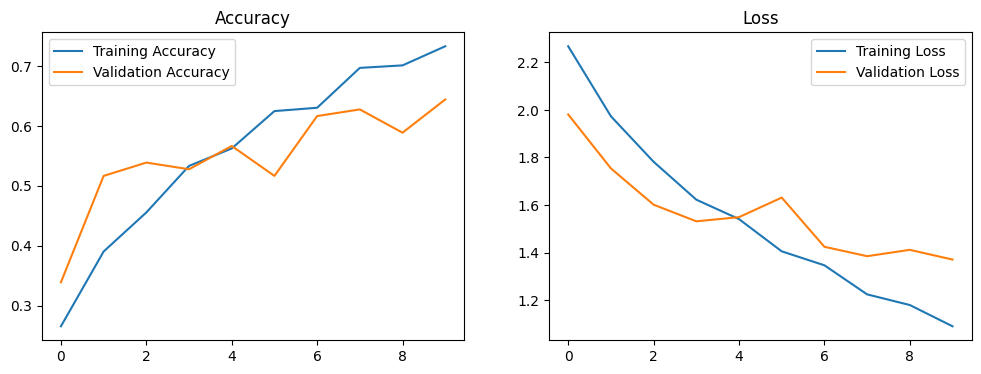

In [111]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [112]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.save('my_m.h5')

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 330ms/step


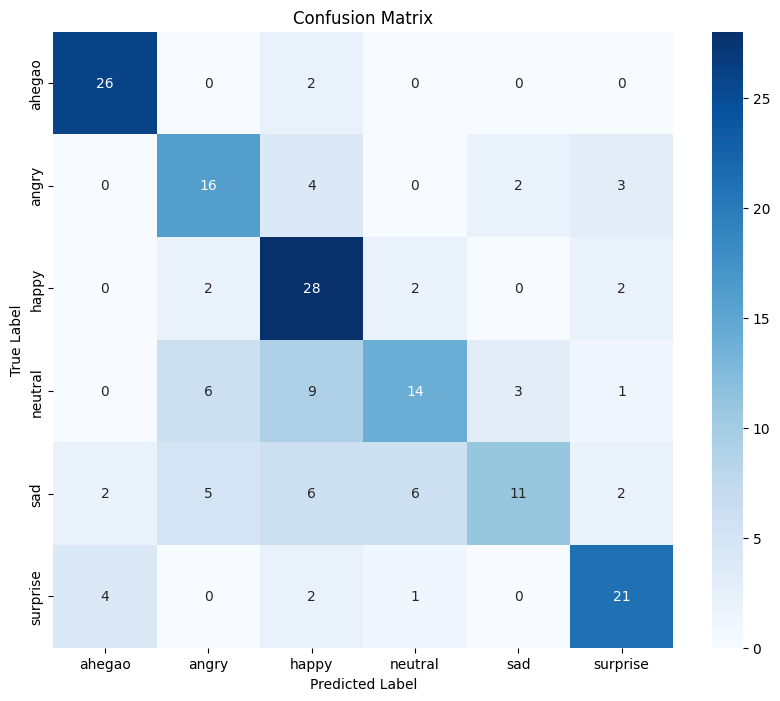

In [113]:
# confusion matrix
X_test = load_and_preprocess_images(test_paths, img_size)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [114]:
# Classification report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

      ahegao       0.81      0.93      0.87        28
       angry       0.55      0.64      0.59        25
       happy       0.55      0.82      0.66        34
     neutral       0.61      0.42      0.50        33
         sad       0.69      0.34      0.46        32
    surprise       0.72      0.75      0.74        28

    accuracy                           0.64       180
   macro avg       0.66      0.65      0.64       180
weighted avg       0.65      0.64      0.63       180



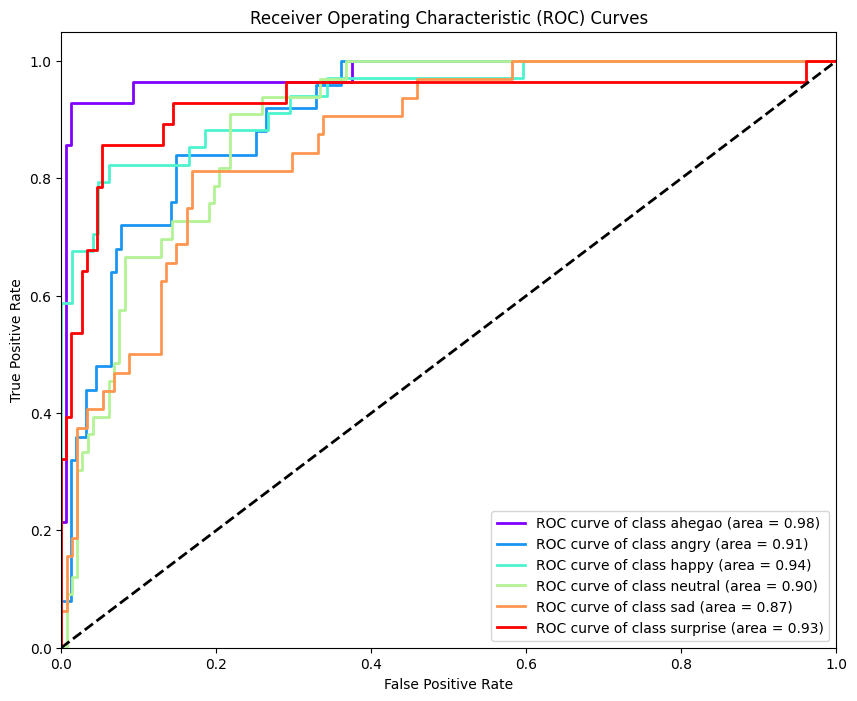

In [115]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(categories)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, len(categories)))
for i, color in zip(range(len(categories)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

Tuning the model

In [116]:
# VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))


In [117]:
# Unfreeze the last 8 layers of VGG16 model
for layer in base_model.layers[:-8]:
    layer.trainable = False


In [118]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(len(categories), activation='softmax')(x)

In [119]:
model = Model(inputs=base_model.input, outputs=predictions)

In [120]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [121]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)


In [122]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [123]:
# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(load_and_preprocess_images(test_paths, img_size), y_test), epochs=10, callbacks=[early_stopping])


Epoch 1/10


c:\Users\Ajit\Desktop\Project\Dl\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 674ms/step - accuracy: 0.2017 - loss: 2.3711 - val_accuracy: 0.2333 - val_loss: 2.2763
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 675ms/step - accuracy: 0.1911 - loss: 2.2790 - val_accuracy: 0.1667 - val_loss: 2.1963
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 685ms/step - accuracy: 0.2185 - loss: 2.2072 - val_accuracy: 0.2556 - val_loss: 2.1352
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 682ms/step - accuracy: 0.2436 - loss: 2.1602 - val_accuracy: 0.3111 - val_loss: 2.0540
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 674ms/step - accuracy: 0.2448 - loss: 2.1026 - val_accuracy: 0.3333 - val_loss: 1.9790
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 654ms/step - accuracy: 0.3032 - loss: 1.9977 - val_accuracy: 0.3944 - val_loss: 1.8136
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 661ms/step - accuracy: 0.3813 - loss: 1.8448 - val_accuracy: 0.3944 - val_loss: 1.7795
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 658ms/step - accuracy: 0.4459 - loss: 1.7109 - val_accuracy: 0.461

In [124]:
# Evaluate the model
loss, accuracy = model.evaluate(load_and_preprocess_images(test_paths, img_size), y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step - accuracy: 0.5303 - loss: 1.4126
Test Loss: 1.4359880685806274
Test Accuracy: 0.5277777910232544


In [125]:
# Print the final training accuracy
training_accuracy = history.history['accuracy'][-1]
print(f"Final Training Accuracy: {training_accuracy}")

Final Training Accuracy: 0.5249999761581421


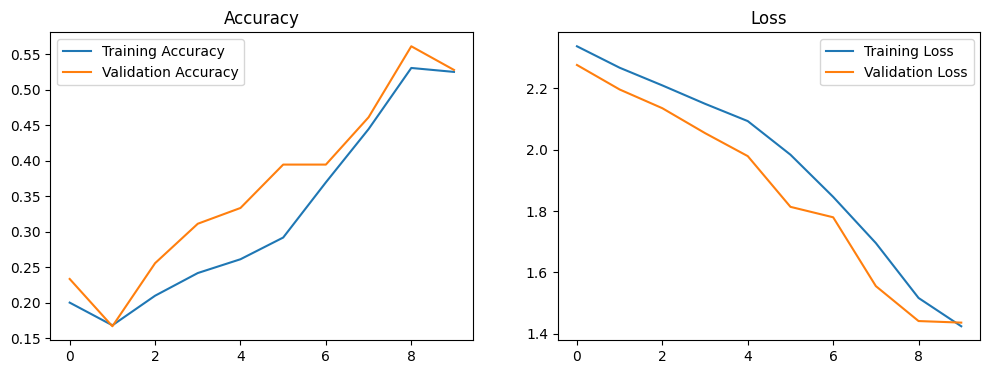

In [126]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step


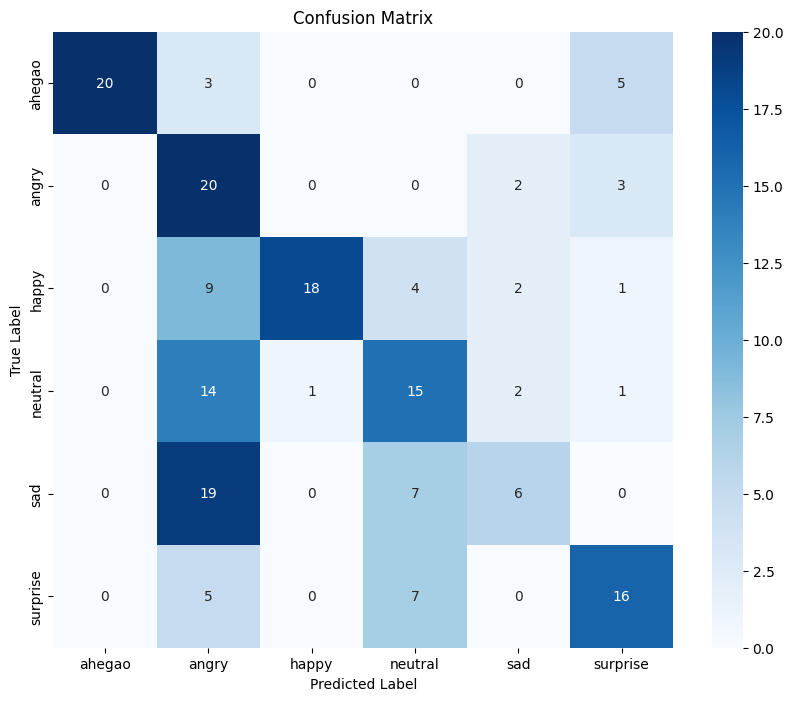

In [127]:
# Display a confusion matrix
X_test = load_and_preprocess_images(test_paths, img_size)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [128]:
# Classification report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

      ahegao       1.00      0.71      0.83        28
       angry       0.29      0.80      0.42        25
       happy       0.95      0.53      0.68        34
     neutral       0.45      0.45      0.45        33
         sad       0.50      0.19      0.27        32
    surprise       0.62      0.57      0.59        28

    accuracy                           0.53       180
   macro avg       0.63      0.54      0.54       180
weighted avg       0.64      0.53      0.54       180



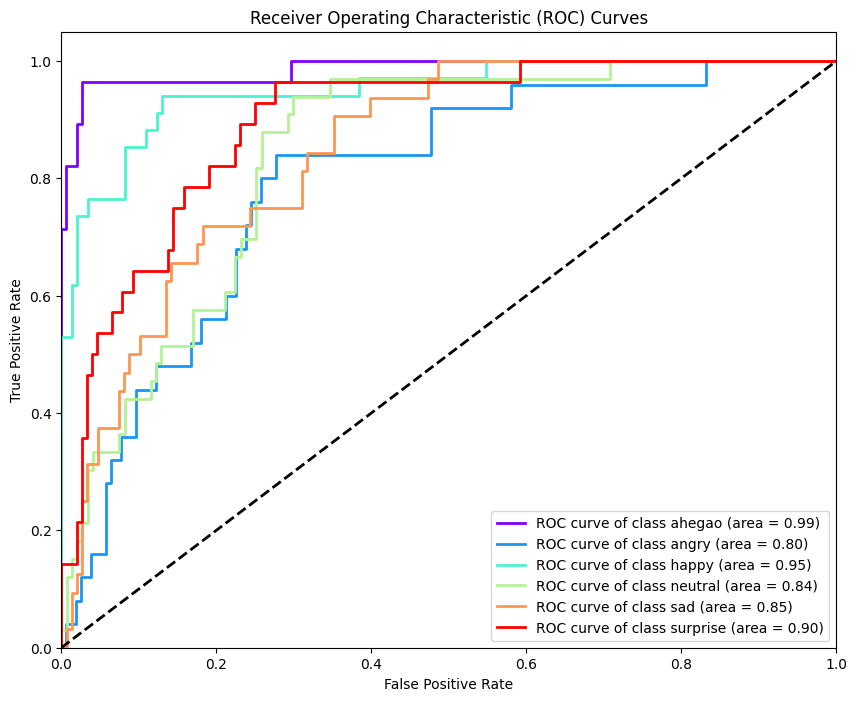

In [129]:
# Plot ROC curves
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(categories)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, len(categories)))
for i, color in zip(range(len(categories)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

In [130]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.save('my_m.h5')